In [40]:
from sklearn.preprocessing import LabelEncoder, StandardScaler 
import pickle
import pandas as pd
import numpy as np
import os

import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import display
from pathlib import Path

from pydub import AudioSegment
#import keras

In [41]:
nirvana_folder = "E:/DS/Projects/tunes/Song_repo/Nirvana"
nirvana_wav = "E:/DS/Projects/tunes/Song_repo/Nirvana_wav"

Nirvana_music_list = os.listdir(nirvana_wav)

In [42]:
Nirvana_music_list

['Daniel Castro - Ill Play The Blues For You.wav',
 'martin-garrix-animals-original-mix (online-audio-converter.com).wav',
 'Nirvana - Bleach - 01 - Blew.mp3',
 'Nirvana - Bleach - 02 - Floyd The Barber.mp3',
 'Nirvana - Bleach - 03 - About A Girl.mp3',
 'Nirvana - Bleach - 04 - School.mp3',
 'Nirvana - Bleach - 05 - Love Buzz.mp3',
 'Nirvana - Bleach - 06 - Paper Cuts.mp3',
 'Nirvana - Bleach - 07 - Negative Creep.mp3',
 'Nirvana - Bleach - 08 - Scoff.mp3',
 'Nirvana - Bleach - 09 - Swap Meet.mp3',
 'Nirvana - Bleach - 10 - Mr. Moustache.mp3',
 'Nirvana - Bleach - 11 - Sifting.mp3',
 'Nirvana - Bleach - 12 - Big Cheese.mp3',
 'Nirvana - Bleach - 13 - Downer.mp3',
 'Nirvana - From The Muddy Banks Of The Wishkah - 01 - Intro.mp3',
 'Nirvana - From The Muddy Banks Of The Wishkah - 02 - School.mp3',
 'Nirvana - From The Muddy Banks Of The Wishkah - 03 - Drain You.mp3',
 'Nirvana - From The Muddy Banks Of The Wishkah - 04 - Aneurysm.mp3',
 'Nirvana - From The Muddy Banks Of The Wishkah - 0

In [43]:
#music_list = str(nirvana_wav) + "/" + str(Nirvana_music_list[0])
music_list = Nirvana_music_list[1:2]

In [44]:
music_list

['martin-garrix-animals-original-mix (online-audio-converter.com).wav']

In [45]:
data = pd.DataFrame()

for song in music_list:

    curr_track = nirvana_wav + "/" + str(song)
    y, sr = librosa.load(curr_track)
    
    i = 0
    while i < (len(y)-64001):
        start = i
        end = i+64000
        segment = y[start:end]
                        
        tempo, beats = librosa.beat.beat_track(y=segment, sr=sr)
        spec_cent = np.median(librosa.feature.spectral_centroid(y=segment, sr=sr))
        spec_bw = np.median(librosa.feature.spectral_bandwidth(y=segment, sr=sr))
        rolloff = np.median(librosa.feature.spectral_rolloff(y=segment, sr=sr))
        zcr = np.median(librosa.feature.zero_crossing_rate(segment))
        
        try:
            chroma = librosa.feature.chroma_cqt(segment,sr)
        except:
            chroma = np.zeros(1512).reshape((12,126))
            
        chroma_median = []
        for c in chroma.reshape(126,12):
            chroma_median.append(np.median(c))
            
        beat_features = np.array(chroma_median)
            
        df_list = [tempo, spec_cent, spec_bw, rolloff, zcr, beat_features]
        data = data.append(pd.Series(df_list),ignore_index=True)
        
        i = i+64000

In [46]:
data.head()

,0,1,2,3,4,5
0,129.199219,4421.058667,3225.427364,8925.512695,0.349609,"[0.776113776905484, 0.6741895301269929, 0.5064..."
1,129.199219,3782.154557,3253.434465,8451.782227,0.245605,"[0.5560553983637235, 0.9000544441579901, 0.553..."
2,129.199219,3273.539740,3211.410464,7784.252930,0.193848,"[0.6958353523993848, 0.7362975960963025, 0.835..."
3,129.199219,2831.371891,3002.648361,7159.790039,0.151123,"[0.6857477850844081, 0.6148514415208819, 0.865..."
4,129.199219,2568.904603,2670.017913,5743.981934,0.116211,"[0.7132110971277774, 0.4840271098344161, 0.767..."


In [47]:
data.columns = ['tempo', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'beat_features']

col_list = []
for i in range(1, data.beat_features[0].shape[0]+1):
    col_list.append("cqt_"+str(i))
    
df = data.beat_features.apply(pd.Series)
df.columns = col_list

data = pd.concat([data,df], axis=1)

data.drop(columns = ['beat_features'], inplace = True)

In [48]:
feature_list = data
feature_list.to_csv('EDM.csv')

In [18]:
feature_list['OA_spec'] = feature_list.drop(columns = ['tempo','spec_cent','spec_bw','rolloff','zcr']).median(axis = 1, skipna = True)

feature_list = feature_list[['tempo','spec_cent','spec_bw','rolloff','zcr','OA_spec']]
ftrs = feature_list

scaler = StandardScaler()
X = scaler.fit_transform(np.array(ftrs, dtype = float))

filename = 'genre_detector.sav'
model = pickle.load(open(filename, 'rb'))

predictions = model.predict(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


ModuleNotFoundError: No module named 'keras'

In [31]:
genres = ['Country','EDM','Hip-Hop','Jazz','Pop','RnB','Rock','Trance']

result_df = pd.DataFrame(predictions)
result_df.columns = genres

result = result_df.mean(axis = 0, skipna = True)

In [32]:
result.loc[result == result.max()].index

Index(['Rock'], dtype='object')

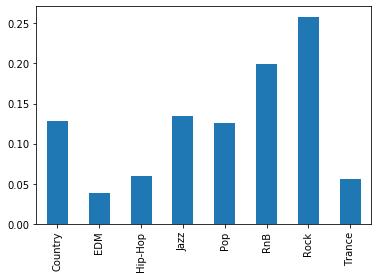

In [33]:
result.sort_values(ascending = False).plot.bar()